## NB - binary classification

In [1277]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [1278]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

### tolgo record con outliers 

In [1279]:
pp_class = pp_class[pp_class["outlier_w_type"] != True]
pp_test_class = pp_test_class[pp_test_class["outlier_w_type"] != True]

## Filtro dataset su classi meno rappresentate -> capire se 1,5,6,9 o 7,8,9

In [1280]:
 #pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

### preprocessing variabili

In [1281]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)



In [1282]:
column2drop = ['originalTitle', 'runtimeMinutes']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

#### endYear da gestire

In [1283]:
pp_class= pp_class.drop(["endYear"], axis=1)
pp_test_class= pp_test_class.drop(["endYear"], axis=1)

#### Discretizzazione delle numeriche

In [1284]:
#TOTAL NOMINATIONS E TOTAL MEDIA
# 1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)

# pp_class['totalNominations_bin'] = (pp_class['totalNominations'] > 0).astype(int)
# pp_class['totalMedia_bin'] = (pp_class['totalMedia'] > 0).astype(int)

# pp_test_class['totalNominations_bin'] = (pp_test_class['totalNominations'] > 0).astype(int)
# pp_test_class['totalMedia_bin'] = (pp_test_class['totalMedia'] > 0).astype(int)


In [1285]:
#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_class['totalNominations_bin'] = pd.cut(pp_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

bins = [-1, 0, 2, 10, pp_test_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_test_class['totalNominations_bin'] = pd.cut(pp_test_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_class['totalMedia_bin'] = pd.cut(pp_class['totalMedia'], bins=bins, labels=labels)


bins = [-1, 0, 1, 8, 50, pp_test_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_test_class['totalMedia_bin'] = pd.cut(pp_test_class['totalMedia'], bins=bins, labels=labels)


In [1286]:
#train

#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90, pp_class['fill_runtimeMinutes_Bruno'].max()]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_class['runtime_bin'] = pd.cut(pp_class['fill_runtimeMinutes_Bruno'], bins=bins, labels=labels)


#RATING 
bins = [-1, 3, 6, 7, 8, pp_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_class['rating_bin'] = pd.cut(pp_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_class['numVotes_bin'] = pd.cut(pp_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1878,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_class['startYear_bin'] = pd.cut(pp_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]
pp_class['totalCredits_bin'] = pd.cut(pp_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_class['criticReviewsTotal_bin'] = pd.cut(pp_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_class['numRegions_bin'] = pd.cut(pp_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]
pp_class['userReviewsTotal_bin'] = pd.cut(pp_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN freq-> 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']
pp_class["country_freq_bin"] = pd.cut( pp_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_class, "countryOfOrigin_UNK", "from_Unknown")

# BINARIZZAZIONE 
def genre_column(df, col_name, genre):
    new_col = f'{genre}_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{genre}_genre'
       # elif value == 1:
        #    return f'one_{genre}'
        else:
            return f'1_is_{genre}_genre'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
genre_column(pp_class, "is_Documentary", "documentary")
genre_column(pp_class, "is_History", "history")
genre_column(pp_class, "is_Adventure", "adventure")
genre_column(pp_class, "is_Thriller", "thriller")
genre_column(pp_class, "is_Game-Show", "game-show")
genre_column(pp_class, "is_Comedy", "comedy")
genre_column(pp_class, "is_Sci-Fi", "sci-fi")
genre_column(pp_class, "is_Romance", "romance")
genre_column(pp_class, "is_Biography", "biography")
genre_column(pp_class, "is_Musical", "musical")
genre_column(pp_class, "is_Western", "western")
genre_column(pp_class, "is_Music", "music")
genre_column(pp_class, "is_Film-Noir", "film-noir")
genre_column(pp_class, "is_Adult", "adult")
genre_column(pp_class, "is_Reality-TV", "reality-tv")
genre_column(pp_class, "is_News", "news")
genre_column(pp_class, "is_Action", "action")
genre_column(pp_class, "is_Crime", "crime")
genre_column(pp_class, "is_Short", "short")
genre_column(pp_class, "is_Fantasy", "fantasy")
genre_column(pp_class, "is_Family", "family")
genre_column(pp_class, "is_Mystery", "mystery")
genre_column(pp_class, "is_Talk-Show", "talk-show")
genre_column(pp_class, "is_Drama", "drama")
genre_column(pp_class, "is_Sport", "sport")
genre_column(pp_class, "is_War", "war")
genre_column(pp_class, "is_Horror", "horror")
genre_column(pp_class, "is_Animation", "animation")







In [1287]:
#train

#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90, pp_test_class['fill_runtimeMinutes_Bruno'].max()]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_test_class['runtime_bin'] = pd.cut(pp_test_class['fill_runtimeMinutes_Bruno'], bins=bins, labels=labels)


#RATING 
bins = [-1, 3, 6, 7, 8, pp_test_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_test_class['rating_bin'] = pd.cut(pp_test_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_test_class['numVotes_bin'] = pd.cut(pp_test_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1877,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_test_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_test_class['startYear_bin'] = pd.cut(pp_test_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]

pp_test_class['totalCredits_bin'] = pd.cut(pp_test_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_test_class['criticReviewsTotal_bin'] = pd.cut(pp_test_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_test_class['numRegions_bin'] = pd.cut(pp_test_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]

pp_test_class['userReviewsTotal_bin'] = pd.cut(pp_test_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN FREQ ENC 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']

pp_test_class["country_freq_bin"] = pd.cut( pp_test_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_test_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_test_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_test_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_test_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_test_class, "countryOfOrigin_UNK", "from_Unknown")



# BINARIZZAZIONE 
def genre_column(df, col_name, genre):
    new_col = f'{genre}_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{genre}_genre'
       # elif value == 1:
        #    return f'one_{genre}'
        else:
            return f'1_is_{genre}_genre'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
genre_column(pp_test_class, "is_Documentary", "documentary")
genre_column(pp_test_class, "is_History", "history")
genre_column(pp_test_class, "is_Adventure", "adventure")
genre_column(pp_test_class, "is_Thriller", "thriller")
genre_column(pp_test_class, "is_Game-Show", "game-show")
genre_column(pp_test_class, "is_Comedy", "comedy")
genre_column(pp_test_class, "is_Sci-Fi", "sci-fi")
genre_column(pp_test_class, "is_Romance", "romance")
genre_column(pp_test_class, "is_Biography", "biography")
genre_column(pp_test_class, "is_Musical", "musical")
genre_column(pp_test_class, "is_Western", "western")
genre_column(pp_test_class, "is_Music", "music")
genre_column(pp_test_class, "is_Film-Noir", "film-noir")
genre_column(pp_test_class, "is_Adult", "adult")
genre_column(pp_test_class, "is_Reality-TV", "reality-tv")
genre_column(pp_test_class, "is_News", "news")
genre_column(pp_test_class, "is_Action", "action")
genre_column(pp_test_class, "is_Crime", "crime")
genre_column(pp_test_class, "is_Short", "short")
genre_column(pp_test_class, "is_Fantasy", "fantasy")
genre_column(pp_test_class, "is_Family", "family")
genre_column(pp_test_class, "is_Mystery", "mystery")
genre_column(pp_test_class, "is_Talk-Show", "talk-show")
genre_column(pp_test_class, "is_Drama", "drama")
genre_column(pp_test_class, "is_Sport", "sport")
genre_column(pp_test_class, "is_War", "war")
genre_column(pp_test_class, "is_Horror", "horror")
genre_column(pp_test_class, "is_Animation", "animation")





#### one hot encoding titletype forse va anche così

In [1288]:
from sklearn.preprocessing import OneHotEncoder

# Estrai la colonna da codificare
title_type = pp_class[['titleType']]
title_type_test = pp_test_class[['titleType']]

# Inizializza l'encoder
encoder = OneHotEncoder(sparse=False, drop=None)  # drop='first' se vuoi evitare collinearità

# Esegui la codifica
title_encoded = encoder.fit_transform(title_type)
title_encoded_test = encoder.transform(title_type_test)

# Crea un DataFrame con i nomi delle colonne
title_encoded_df = pd.DataFrame(title_encoded, columns=encoder.get_feature_names_out(['titleType']))
title_encoded_df_test = pd.DataFrame(title_encoded_test, columns=encoder.get_feature_names_out(['titleType']))


# Unisci al dataset originale
pp_class= pd.concat([pp_class.reset_index(drop=True), title_encoded_df], axis=1)
pp_test_class= pd.concat([pp_test_class.reset_index(drop=True), title_encoded_df_test], axis=1)


# (Facoltativo) Rimuovi la colonna originale
pp_class#.drop(columns=['titleType'], inplace=True)


C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,rating,startYear,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,...,horror_bin,animation_bin,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,titleType_tvSpecial,titleType_video
0,8,1995,0.0,779,1,0,21,1,tvEpisode,0,...,0_not_horror_genre,1_is_animation_genre,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,6,1992,0.0,38,1,0,24,0,movie,0,...,0_not_horror_genre,0_not_animation_genre,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,2021,0.0,15,22,0,56,0,tvSeries,0,...,0_not_horror_genre,0_not_animation_genre,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,9,1995,0.0,14,1,0,0,0,video,0,...,0_not_horror_genre,0_not_animation_genre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8,1995,0.0,96,5,0,110,0,tvEpisode,0,...,0_not_horror_genre,0_not_animation_genre,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14950,8,1984,0.0,1157,13,1,88,2,tvMiniSeries,3,...,0_not_horror_genre,0_not_animation_genre,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14951,6,1942,0.0,73,4,0,45,1,movie,0,...,0_not_horror_genre,0_not_animation_genre,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14952,5,1990,0.0,15,2,0,22,0,movie,0,...,0_not_horror_genre,0_not_animation_genre,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14953,4,1982,0.0,3011,52,1,53,55,movie,0,...,0_not_horror_genre,0_not_animation_genre,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1289]:
pp_class.columns

Index(['rating', 'startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType',
       'awardNominationsExcludeWins',
       ...
       'horror_bin', 'animation_bin', 'titleType_movie', 'titleType_short',
       'titleType_tvEpisode', 'titleType_tvMiniSeries', 'titleType_tvMovie',
       'titleType_tvSeries', 'titleType_tvSpecial', 'titleType_video'],
      dtype='object', length=116)

## Variabile target

In [1290]:
pp_class["has_lowEngagement"] = (pp_class["numVotes"]<100).astype(int)
pp_test_class["has_lowEngagement"] = (pp_test_class["numVotes"]<100).astype(int)

x = sum(pp_class["has_lowEngagement"] == 1)
x

10287

In [1291]:
y_train = np.array(pp_class["has_lowEngagement"]) #target originale
y_test = np.array(pp_test_class["has_lowEngagement"])

## array di valori per selezione feature classificazione

In [1292]:
#  PROVA CATEGORICAL

X_train = pp_class[[
       'rating_bin',
       'totalCredits_bin', 
       'canHaveEpisodes', 
       'numRegions_bin', 
       'country_freq_bin',
       'runtime_bin',  
       'totalNominations_bin',
       'totalMedia_bin',
       'startYear_bin',
       'titleType',

       'from_NorthAmerica_bin','from_Europe_bin' ,
         'from_SouthAmerica_bin',  'from_Asia_bin', 'from_Oceania_bin', 'from_Africa_bin', 
       # 'from_Unknown_bin',
       'documentary_bin', 'history_bin', 'adventure_bin', 'thriller_bin',
       'game-show_bin', 'comedy_bin', 'sci-fi_bin', 'romance_bin',
       'biography_bin', 'musical_bin', 'western_bin', 'music_bin',
       'film-noir_bin', 'adult_bin', 'reality-tv_bin', 'news_bin',
       'action_bin', 'crime_bin', 'short_bin', 'fantasy_bin', 'family_bin',
       'mystery_bin', 'talk-show_bin', 'drama_bin', 'sport_bin', 'war_bin',
       'horror_bin', 'animation_bin'


       ]].values

X_test = pp_test_class[[      
       'rating_bin',
       'totalCredits_bin', 
       'canHaveEpisodes', 
       'numRegions_bin', 
       'country_freq_bin',
       'runtime_bin',  
       'totalNominations_bin',
       'totalMedia_bin',
       'startYear_bin',
       'titleType',

       'from_NorthAmerica_bin','from_Europe_bin' ,
         'from_SouthAmerica_bin',  'from_Asia_bin', 'from_Oceania_bin', 'from_Africa_bin', 
        #'from_Unknown_bin',

       'documentary_bin', 'history_bin', 'adventure_bin', 'thriller_bin',
       'game-show_bin', 'comedy_bin', 'sci-fi_bin', 'romance_bin',
       'biography_bin', 'musical_bin', 'western_bin', 'music_bin',
       'film-noir_bin', 'adult_bin', 'reality-tv_bin', 'news_bin',
       'action_bin', 'crime_bin', 'short_bin', 'fantasy_bin', 'family_bin',
       'mystery_bin', 'talk-show_bin', 'drama_bin', 'sport_bin', 'war_bin',
       'horror_bin', 'animation_bin'

       ]].values



In [1293]:
# valutare country
        # 'from_NorthAmerica_bin','from_Europe_bin' , 'from_SouthAmerica_bin', 
        # 'from_Asia_bin', 'from_Oceania_bin', 'from_Africa_bin', 
        # 'from_Unknown_bin'

#valutare generi
# 'documentary_bin', 'history_bin', 'adventure_bin', 'thriller_bin',
#        'game-show_bin', 'comedy_bin', 'sci-fi_bin', 'romance_bin',
#        'biography_bin', 'musical_bin', 'western_bin', 'music_bin',
#        'film-noir_bin', 'adult_bin', 'reality-tv_bin', 'news_bin',
#        'action_bin', 'crime_bin', 'short_bin', 'fantasy_bin', 'family_bin',
#        'mystery_bin', 'talk-show_bin', 'drama_bin', 'sport_bin', 'war_bin',
#        'horror_bin', 'animation_bin'


In [1294]:
# #altra comb che andava meglio come accuracy ma con roc + bass

# 'rating_bin',
#        'startYear_bin',        
#        'numVotes_bin',
#        'totalCredits_bin', 
#        'criticReviewsTotal_bin',
#        'canHaveEpisodes', 
#        'userReviewsTotal_bin',
#        'runtime_bin',
#         'totalNominations_bin',
#        # 'numRegions_bin',
#         'titleType_movie','titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries','titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvShort', 'titleType_tvSpecial', 'titleType_video'
       

In [1295]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


### Splitting in validation

In [1296]:
#CATEGORICAL NB
X_train2, X_val, y_train2, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=32)

In [1297]:
print(X_train2.shape, X_val.shape, X_train.shape,
      #, X_test.shape
      )

(11964, 44) (2991, 44) (14955, 44)


In [1298]:

X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## NAIVE BAYES

### Categorical

In [1299]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) -> non va perchè ci sono valori negativi
clf = CategoricalNB()
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

Predicting on validation set

In [1300]:
y_pred = clf.predict(X_val_tr)

In [1301]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

2991
2991


In [1302]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1}
{0, 1}


Classification report

In [1303]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8131059846205283

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       938
           1       0.86      0.86      0.86      2053

    accuracy                           0.81      2991
   macro avg       0.78      0.78      0.78      2991
weighted avg       0.81      0.81      0.81      2991



In [1304]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[0.90345636, 0.09654364],
       [0.00463547, 0.99536453],
       [0.74985412, 0.25014588],
       ...,
       [0.10288565, 0.89711435],
       [0.02563419, 0.97436581],
       [0.61344543, 0.38655457]])

overfitting

Performance sul Training set:
Accuracy: 0.8058
F1 Score: 0.8059

Performance sul Validation set:
Accuracy: 0.8131
F1 Score: 0.8131


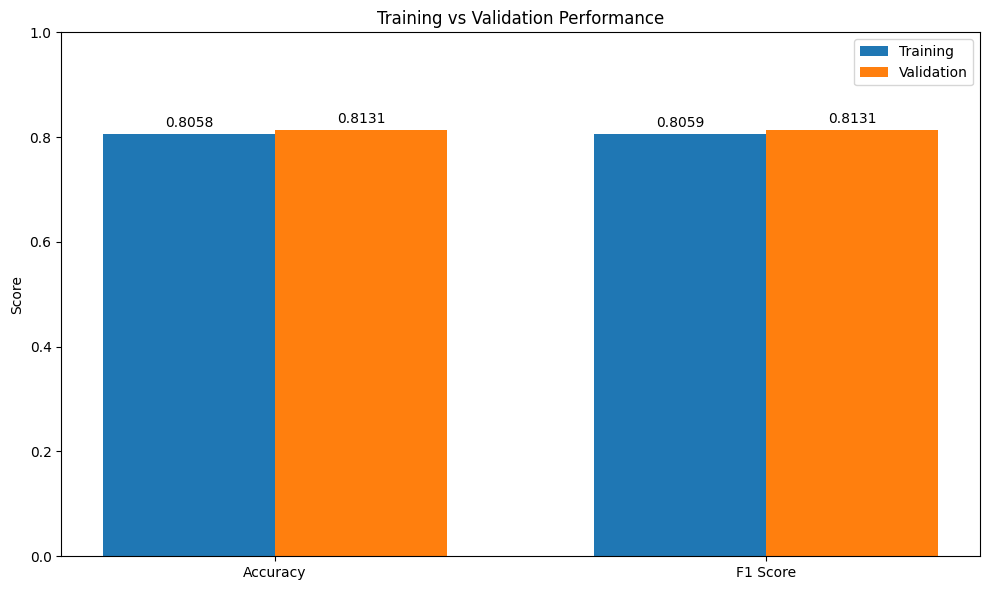

In [1305]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

In [1306]:
print("y_val shape:", y_val.shape)
print("y_val dtype:", y_val.dtype)
print("primi elementi di y_val:", y_val[:5])  # Mostra i primi 5 elementi

y_val shape: (2991,)
y_val dtype: int32
primi elementi di y_val: [1 1 0 1 1]


In [1307]:
# plot_roc(y_val, clf.predict_proba(X_val_tr))
# plt.show()
# print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

prova 2 roc

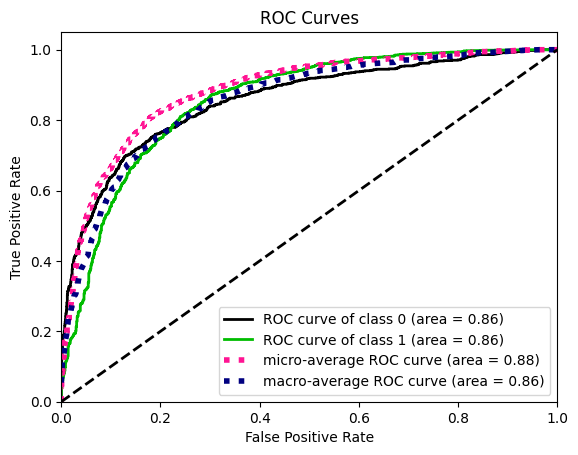

0.8559336952423879


In [1308]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

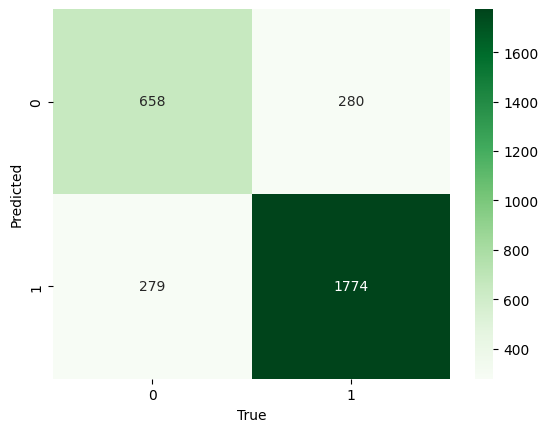

In [1309]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

Distribuzioni classi nel train2

In [1310]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3730
1    8234
Name: count, dtype: int64


## Proper testing on the test set

In [1311]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred

array([1, 0, 1, ..., 1, 0, 1])

Performance sul Training set:
Accuracy: 0.8069
F1 Score: 0.8071

Performance sul test set:
Accuracy: 0.8019
F1 Score: 0.8019


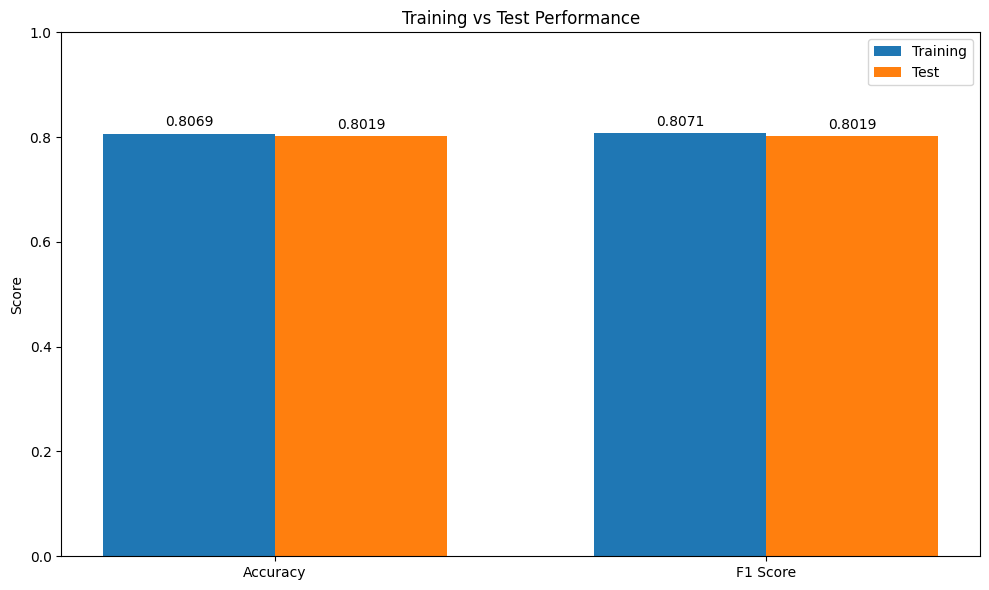

In [1312]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [1313]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.8018886879646373

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1561
           1       0.86      0.86      0.86      3416

    accuracy                           0.80      4977
   macro avg       0.77      0.77      0.77      4977
weighted avg       0.80      0.80      0.80      4977



In [1314]:
clf.predict_proba(X_test_tr)
#prob che un record appartenga alle classi

array([[0.00911865, 0.99088135],
       [0.70950455, 0.29049545],
       [0.02096129, 0.97903871],
       ...,
       [0.02442595, 0.97557405],
       [0.92305758, 0.07694242],
       [0.01433191, 0.98566809]])

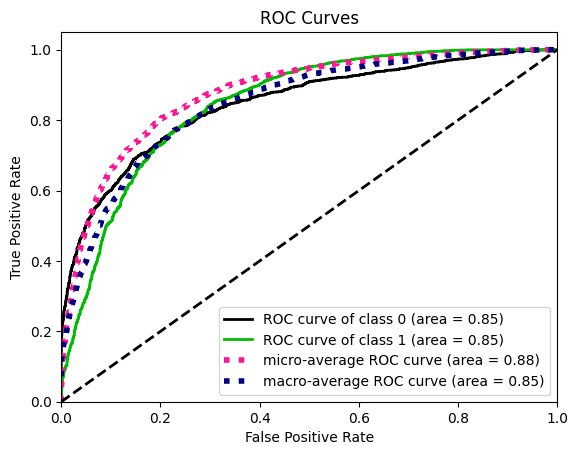

0.8467561177231313


In [1315]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_test_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_test, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_test, probs[:, 1]))

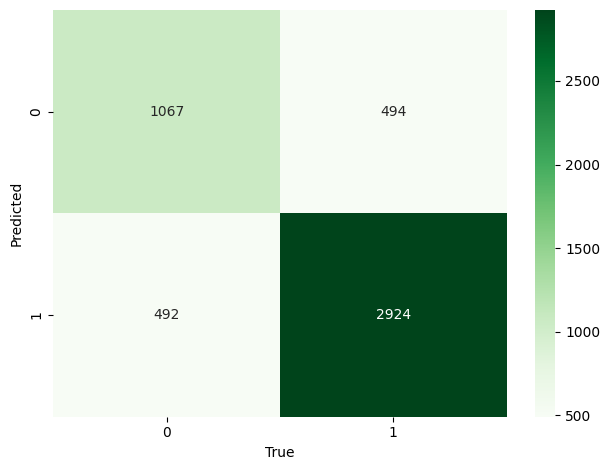

In [1316]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### devo cambiare qlcs? Dummy classifier

In [1317]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6863572433192686
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1561
           1       0.69      1.00      0.81      3416

    accuracy                           0.69      4977
   macro avg       0.34      0.50      0.41      4977
weighted avg       0.47      0.69      0.56      4977



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# "lowEngagement"

In [1318]:
pp_class["lowEngagement"] = (pp_class["numVotes"]<100).astype(int)
pp_test_class["lowEngagement"] = (pp_test_class["numVotes"]<100).astype(int)

In [1319]:
x = sum(pp_class["lowEngagement"] == 1)
x

10287

Selezione variabile target

In [1320]:
y_train = np.array(pp_class["lowEngagement"]) #target originale
y_test = np.array(pp_test_class["lowEngagement"])

Selezione attributi per classificazione

In [1321]:
X_train = pp_class[[
       'rating_bin',
       'totalCredits_bin', 
       'canHaveEpisodes', 
       'numRegions_bin', 
       'country_freq_bin',
       'runtime_bin',  
       'totalNominations_bin',
       'totalMedia_bin',
       'startYear_bin',
       ]].values

X_test = pp_test_class[[      
       'rating_bin',
       'totalCredits_bin', 
       'canHaveEpisodes', 
       'numRegions_bin', 
       'country_freq_bin',
       'runtime_bin',  
       'totalNominations_bin',
       'totalMedia_bin',
       'startYear_bin',
       ]].values

In [1322]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


In [1323]:
#studio variabili da usare

# X_train = pp_class[[
#        'rating',
#        #'startYear',  
#        #'numVotes', 
#        'totalCredits',  
#        'criticReviewsTotal', # FORSEEEE toglere perchè simili
#        ##'canHaveEpisodes', 
#        ##'isAdult',  -> era simie
#        'numRegions', 
#        'userReviewsTotal', # toglirtr perchè simile
#        ##'endYear',
#        #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
#        #'fill_runtimeMinutes',  #lasciare
#        #'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
#        ##'awardWins_bin',  
#        ##'totalVideos_bin', 
#        ##'awardNominationsExcludeWins_bin', 

#        #'countryOfOrigin', 
#        'countryOfOrigin_freq_enc',
#        #'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK', 
#        'fill_runtimeMinutes_Bruno',  
#        #'totalNominations',
#        #'totalMedia', 
#        'totalNominations_bin',
#       # 'totalMedia_bin',
#       # 'runtimeMinutes_notitletype' 
#        ]].values

# ## X_test = pp_test_class[[ ]].values

Splitting in train-validation

In [1324]:
#CATEGORICAL NB
X_train2, X_val, y_train2, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=32)

In [1325]:
X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## Naive Bayes

In [1326]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) #-> non va perchè ci sono valori negativi
clf = CategoricalNB()
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

Prediction on validation set

In [1327]:
y_pred = clf.predict(X_val_tr)

In [1328]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

2991
2991


In [1329]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8000668672684721

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.61      0.66       938
           1       0.83      0.89      0.86      2053

    accuracy                           0.80      2991
   macro avg       0.77      0.75      0.76      2991
weighted avg       0.79      0.80      0.80      2991



In [1330]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[0.78536384, 0.21463616],
       [0.28060747, 0.71939253],
       [0.79031595, 0.20968405],
       ...,
       [0.03404253, 0.96595747],
       [0.0482873 , 0.9517127 ],
       [0.75849515, 0.24150485]])

Performance sul Training set:
Accuracy: 0.8012
F1 Score: 0.7954

Performance sul Validation set:
Accuracy: 0.8001
F1 Score: 0.7953


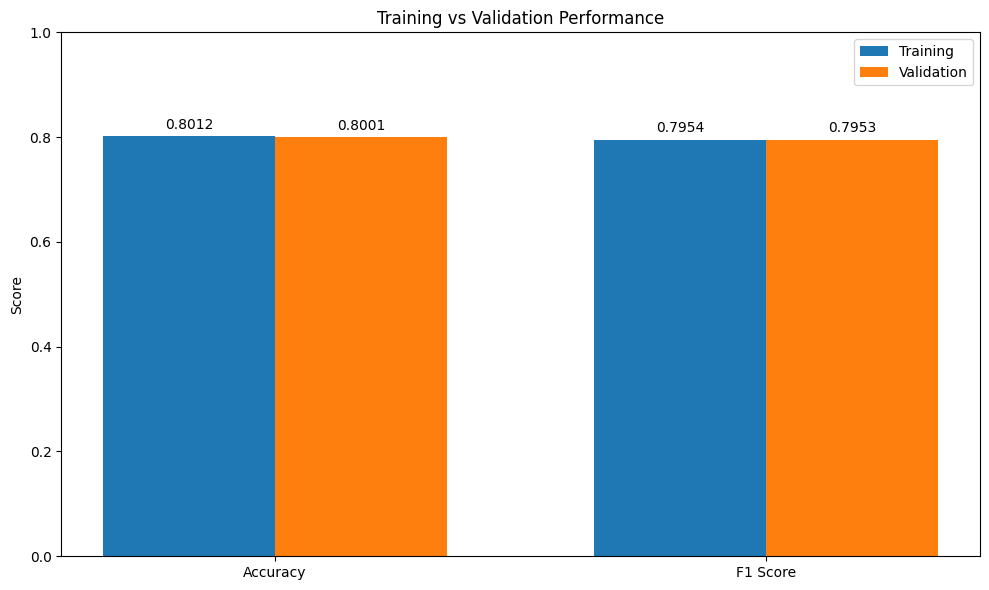

In [1331]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

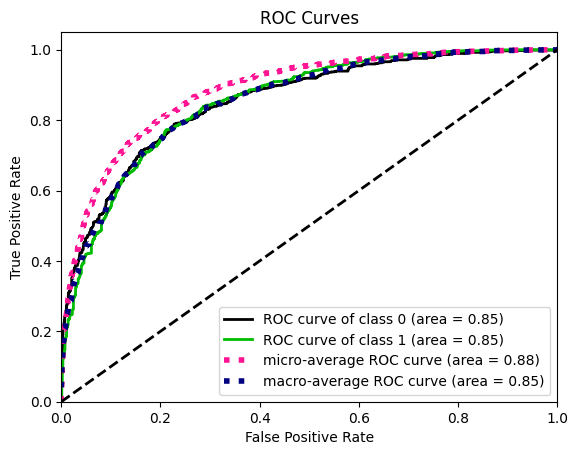

0.8544363285513841


In [1332]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

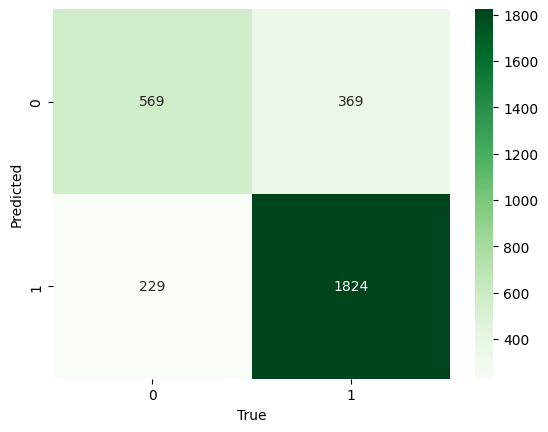

In [1333]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## Prediction on the test set

In [1334]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred

array([1, 0, 1, ..., 1, 0, 1])

Performance sul Training set:
Accuracy: 0.8009
F1 Score: 0.7954

Performance sul test set:
Accuracy: 0.8027
F1 Score: 0.7978


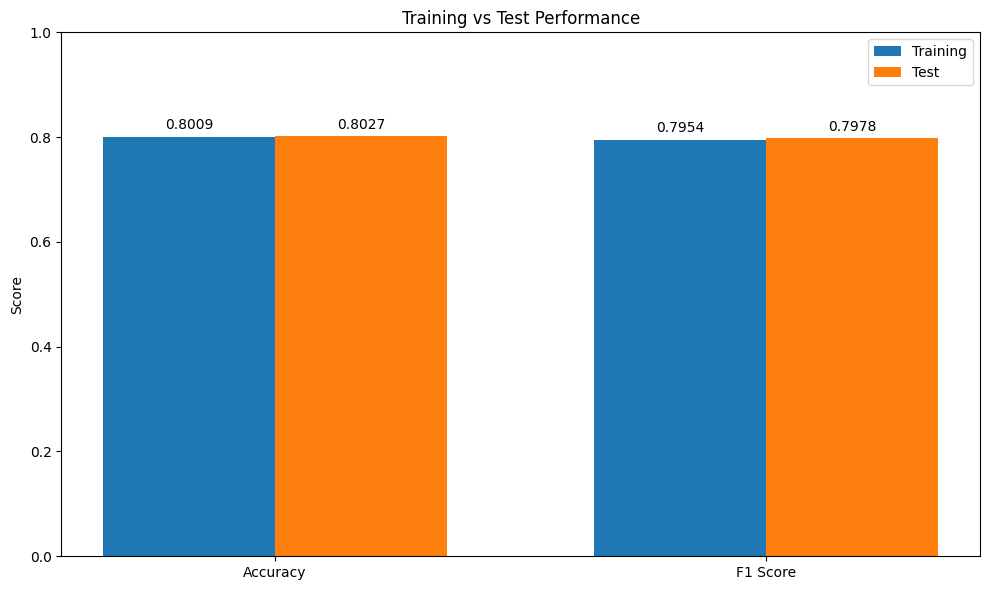

In [1335]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

### risultati test

In [1336]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.802692384970866

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      1561
           1       0.83      0.89      0.86      3416

    accuracy                           0.80      4977
   macro avg       0.78      0.75      0.76      4977
weighted avg       0.80      0.80      0.80      4977



In [1337]:
clf.predict_proba(X_test_tr)
#prob che un record appartenga alle classi

array([[0.1095346 , 0.8904654 ],
       [0.65886647, 0.34113353],
       [0.06959488, 0.93040512],
       ...,
       [0.03337883, 0.96662117],
       [0.91127759, 0.08872241],
       [0.03257889, 0.96742111]])

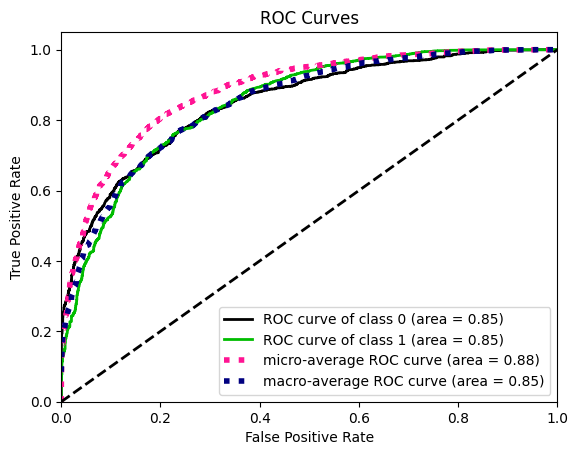

0.8493476454023499


In [1338]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_test_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_test, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_test, probs[:, 1]))

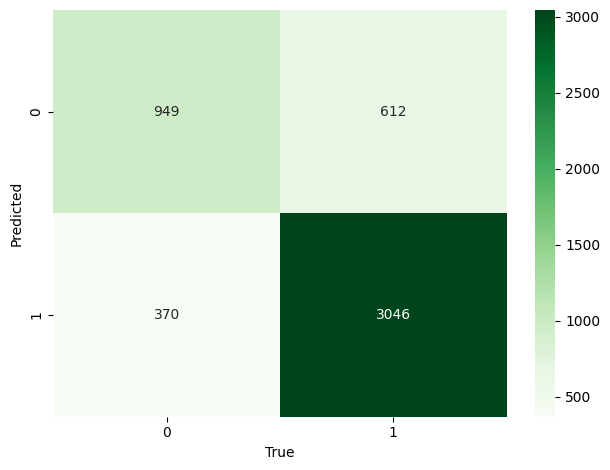

In [1339]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

## Dummy classifier -> cambia qlcs?

In [1340]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6863572433192686
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1561
           1       0.69      1.00      0.81      3416

    accuracy                           0.69      4977
   macro avg       0.34      0.50      0.41      4977
weighted avg       0.47      0.69      0.56      4977



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
